# Extra Credit Assignment

#### GROUP - 4
##### Gauri Ashwini Gakhar - GXG220008
##### Niharika Balkrishan Sharma - NXS210102
##### Riddhi Devang Tripathi - RXT210030

# Avocado Weekly Sales - Forecasting

### 1. Write a few sentences describing the dataset (what is the variable of interest, what is the length of the data….)


##### The dataset contains information about the number of bags of Avocados sold on a daily basis, broken down by bag size and type (conventional or organic).
##### The data is collected from different locations across the United States. The variable of interest is the number of bags sold. The length of the data is more than 30K, and it covers a period of 6 years.
##### Specifically, the dataset contains the following columns:

* date: The date on which the bags were sol average_price: The average price of a bag sold on that date.
* total_volume: The total volume of bags sold on that date.
* total_bags: The total number of bags sold on that date.
* small_bag: The percentage of bags sold that were small.
* large_bags: The percentage of bags sold that were large.
* xlarge_baş: The percentage of bags sold that were extra large.
* type: The type of bag sold (conventional or organic).
* year: The year in which the bags were sold.
* geography: The geographic location where the bags were sold.

##### The dataset is useful for understanding the trends in bag sales over time, and for comparing sales across different locations and types of bags

### 2. Find the optimal model to forecast the values for the next 2 periods. Show the forecast results

We chose Holt-Winters method, also known as triple exponential smoothing (TES), as the optimal model to forecast the values for the next 2 weeks based on several factors:
###### First, Data characteristics:
* Trend: The dataset exhibits a clear trend of increasing sales over time.
* Seasonality: The data also shows evidence of seasonality, with fluctuations in sales volume likely related to specific periods or events

###### Second, Model capabilities:

* TES is specifically designed for time series data with both trend and seasonality.
* TES is flexible and can be adapted to handle different types of seasonality (additive or multiplicative). 
* TES has been shown to be effective in forecasting a wide range of time series data, including sales data. 


In [1]:
import pandas as pd
import numpy as np
import itertools
import datetime as dt

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings("ignore")

### Data Cleansing

In [2]:
sale_data = pd.read_csv('avocado-updated-2020.csv')
sale_data.head()

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,2015,Albany
2,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta
3,2015-01-04,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.0,organic,2015,Atlanta
4,2015-01-04,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,Baltimore/Washington


In [3]:
sale_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30021 entries, 0 to 30020
Data columns (total 13 columns):
date             30021 non-null object
average_price    30021 non-null float64
total_volume     30021 non-null float64
4046             30021 non-null float64
4225             30021 non-null float64
4770             30021 non-null float64
total_bags       30021 non-null float64
small_bags       30021 non-null float64
large_bags       30021 non-null float64
xlarge_bags      30021 non-null float64
type             30021 non-null object
year             30021 non-null int64
geography        30021 non-null object
dtypes: float64(9), int64(1), object(3)
memory usage: 3.0+ MB


In [4]:
sale_data['date'] = pd.to_datetime(sale_data['date'])
sale_data['type'].unique()

array(['conventional', 'organic'], dtype=object)

In [5]:
sale_data['geography'].unique()

array(['Albany', 'Atlanta', 'Baltimore/Washington', 'Boise', 'Boston',
       'Buffalo/Rochester', 'California', 'Charlotte', 'Chicago',
       'Cincinnati/Dayton', 'Columbus', 'Dallas/Ft. Worth', 'Denver',
       'Detroit', 'Grand Rapids', 'Great Lakes', 'Harrisburg/Scranton',
       'Hartford/Springfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'Las Vegas', 'Los Angeles', 'Louisville', 'Miami/Ft. Lauderdale',
       'Midsouth', 'Nashville', 'New Orleans/Mobile', 'New York',
       'Northeast', 'Northern New England', 'Orlando', 'Philadelphia',
       'Phoenix/Tucson', 'Pittsburgh', 'Plains', 'Portland',
       'Raleigh/Greensboro', 'Richmond/Norfolk', 'Roanoke', 'Sacramento',
       'San Diego', 'San Francisco', 'Seattle', 'South Carolina',
       'South Central', 'Southeast', 'Spokane', 'St. Louis', 'Syracuse',
       'Tampa', 'Total U.S.', 'West', 'West Tex/New Mexico'], dtype=object)

In [6]:
# Select US demand for organic avocados
my_data = sale_data[(sale_data['geography'] == 'Total U.S.') &
               (sale_data['type'] == 'organic')][['date', 'total_volume']]
my_data

,date,total_volume
103,2015-01-04,612910.15
211,2015-01-11,669528.88
319,2015-01-18,713120.00
427,2015-01-25,556368.86
535,2015-02-01,740896.97
...,...,...
29584,2020-04-19,2182476.51
29692,2020-04-26,2135665.00
29800,2020-05-03,2157708.00
29908,2020-05-10,2388687.00


In [7]:
my_data['date_diff'] = my_data['date'].diff()
my_data['date_diff'].value_counts()

7 days     271
6 days       3
1 days       1
36 days      1
8 days       1
Name: date_diff, dtype: int64

In [8]:
my_data = my_data[(my_data['date'].dt.year != 2019) &
                  (my_data['date'].dt.year != 2020)].set_index('date')
my_data.drop('date_diff', axis=1, inplace=True)

In [9]:
# Since we have one date difference between Jan 1st 2018 and the last date of 2017
# Examine last date of 2017 and first date of 2018
print(my_data[my_data.index.year == 2017].tail(1))
print(my_data[my_data.index.year == 2018].head(1))

            total_volume
date                    
2017-12-31    1243940.09
            total_volume
date                    
2018-01-01    1243940.09


In [10]:
# This value is duplicated
# There may be a discrepancy among first days of a week  
my_data['weekday'] = my_data.index.strftime('%a')
my_data['weekday'].value_counts()

Sun    205
Mon      1
Name: weekday, dtype: int64

In [11]:
# Drop the first date of 2018, weekday

my_data.drop(pd.Timestamp('2018-01-01'), inplace=True)
my_data.drop('weekday', axis=1, inplace=True)
my_data.rename(columns={'date':'ds', 'total_volume':'y'}, inplace=True)
my_data

,y
date,
2015-01-04,612910.15
2015-01-11,669528.88
2015-01-18,713120.00
2015-01-25,556368.86
2015-02-01,740896.97
...,...
2018-11-04,1436243.31
2018-11-11,1534804.73
2018-11-18,1652276.32


In [12]:
my_data.index.nunique()

205

In [13]:
# Number of observations each year
my_data.index.year.value_counts()

2017    53
2016    52
2015    52
2018    48
Name: date, dtype: int64

### Split Data

In [14]:
# Split data
train = my_data[:181]
test = my_data[181:]
print(train.shape)
print(test.shape)

(181, 1)
(24, 1)


## Data visualization

### Plot the data (train series)
train.plot(figsize=(12,5), legend=None)
plt.title('Organic Avocado Weekly Sales', fontsize=16)
plt.xlabel(None);

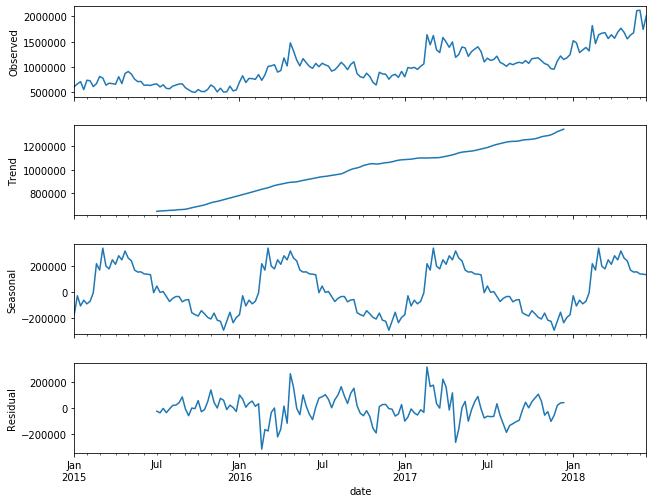

In [15]:
# Another way to decompose the series characteristics
decomposition = seasonal_decompose(train['y'])
fig = decomposition.plot()
fig.set_size_inches(10,8)

## Forecasting
### Exponential Smoothing

In [21]:
# Try multiple combination to find a model that has the lowest RSME
# Try different number of weeks for annual seasonality

trend = ['additive', 'multiplicative']
seasonality = ['additive', 'multiplicative']
periods = range(52, 56)

lowest_rmse = None
lowest_rmse_model = None

for model in list(itertools.product(trend, seasonality, periods)):
    # Modeling
    fcast_model = ExponentialSmoothing(train['y'],
                                       trend=model[0],
                                       seasonal=model[1],
                                       seasonal_periods=model[2]).fit()
    y_fcast = fcast_model.forecast(len(test)).rename('y_fcast')
    
    # RSME
    rmse = np.sqrt(np.mean((test['y'] - y_fcast)**2))
    
    # Store results
    current_rmse = rmse
        
    # Set baseline for rmse
    if lowest_rmse == None:
        lowest_rmse = rmse
        
    # Compare results
    if current_rmse <= lowest_rmse:
        lowest_rmse = current_rmse
        lowest_rmse_model = model      
    print('{} trend, {} seasonality, {} week frequency - RSME: {}'.format(model[0], model[1], model[2], rmse))
    
print('--------------------------------------------------------------------------------------')
print('Model that has the lowest RSME:')
print('{} trend, {} seasonality, {} week frequency - RSME: {}'.format(lowest_rmse_model[0], lowest_rmse_model[1],
                                                                      lowest_rmse_model[2], lowest_rmse))

additive trend, additive seasonality, 52 week frequency - RSME: 445200.6177665481
additive trend, additive seasonality, 53 week frequency - RSME: 350881.5248857919
additive trend, additive seasonality, 54 week frequency - RSME: 333663.96094590036
additive trend, additive seasonality, 55 week frequency - RSME: 410158.8829451391
additive trend, multiplicative seasonality, 52 week frequency - RSME: 152999.66077359513
additive trend, multiplicative seasonality, 53 week frequency - RSME: 137883.72443093412
additive trend, multiplicative seasonality, 54 week frequency - RSME: 136956.87091084593
additive trend, multiplicative seasonality, 55 week frequency - RSME: 175647.85360689534
multiplicative trend, additive seasonality, 52 week frequency - RSME: 813005.4431450857
multiplicative trend, additive seasonality, 53 week frequency - RSME: 444886.4754973986
multiplicative trend, additive seasonality, 54 week frequency - RSME: 407537.4349292683
multiplicative trend, additive seasonality, 55 week

In [22]:
def error_metrics(y_fcast, y_test):
    """
    Return mean absolute percentage error (MAPE)
           mean percentage error (MPE)
           mean absolute error (MAE)
           root mean square error (RMSE)
           
    """
    print(f'MAPE: {np.mean(np.abs((y_test - y_fcast)/y_test))*100}')
    print(f'MPE:  {np.mean((y_test - y_fcast)/y_test)*100}')
    print(f'MAE:  {np.mean(np.abs(y_test - y_fcast))*100}')
    print(f'RMSE: {np.sqrt(np.mean((y_test - y_fcast)**2))}')
    

def exp_smoothing(y_train,
                  y_test,
                  trend=None,
                  seasonal=None,
                  period=None,
                  freq=None,
                  plot=False,
                  figsize=None):
    """
    Forecast using Holt-Winters exponential smoothing.
    Return a graph and error metrics.
    """
    # Modeling
    fcast_model = ExponentialSmoothing(y_train,
                                       trend=trend,
                                       seasonal=seasonal,
                                       seasonal_periods=period).fit()
    y_est = pd.DataFrame(fcast_model.fittedvalues).rename(columns={0:'y_fitted'}) # In-sample fit
    y_fcast = fcast_model.forecast(len(y_test)).rename('y_fcast') # Out-of-sample fit
    
    # Plot Series
    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
        ax.set_title('Observed, Fitted, and Forecasted Series\nTriple Exponential Smoothing',
                     fontsize=16)
        ax.set_ylabel('Organic Avocado Weekly Sales')
        ax.plot(y_train,
                label='In-sample data',
                linestyle='-')
        ax.plot(y_test,
                label='Held-out data',
                linestyle='-')
        ax.plot(y_est,
                label='Fitted values',
                linestyle='--',
                color='g')
        ax.plot(y_fcast,
                label='Forecasts',
                linestyle='--',
                color='k')
        ax.legend(loc='best')
        plt.xticks(rotation = 45)
        plt.show(block = False)
        plt.close()
    
    # Print error metrics
    print('-----------------------------')
    if seasonal != None:
        print('{} trend, {} seasonality, {} {} frequency'.format(trend, seasonal, period, freq))
    error_metrics(y_fcast=y_fcast, y_test=y_test)
    print(f'AIC:  {fcast_model.aic}')
    print(f'BIC:  {fcast_model.bic}')

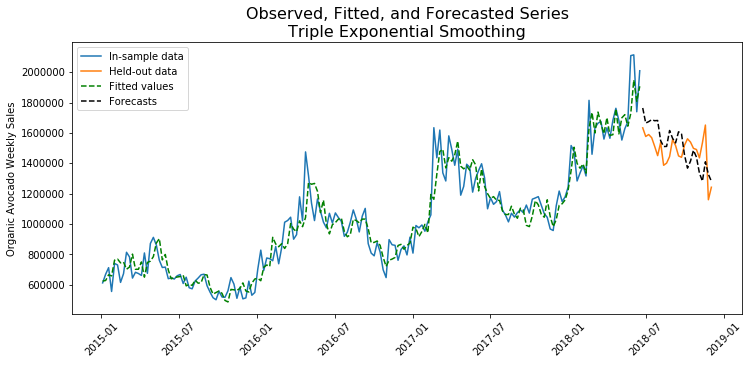

-----------------------------
additive trend, multiplicative seasonality, 53 week frequency
MAPE: 7.962646847844161
MPE:  -2.377963830932314
MAE:  11780178.96635814
RMSE: 137883.72443093412
AIC:  4286.236474818653
BIC:  4468.550805600805


In [18]:
exp_smoothing(train['y'],
              test['y'],
              trend='additive',
              seasonal='multiplicative',
              period=53,
              freq='week',
              plot=True,
              figsize=(12,5))

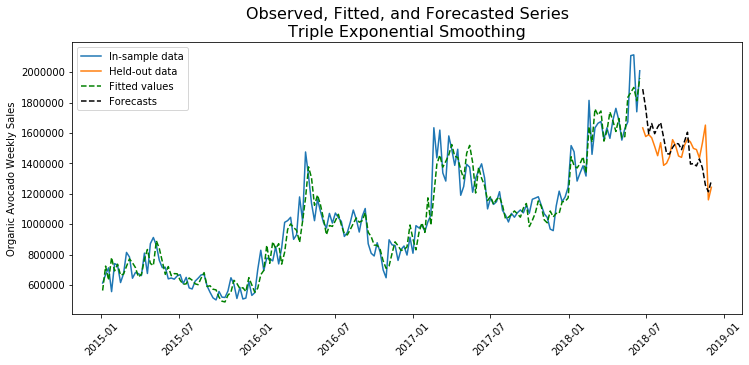

-----------------------------
additive trend, multiplicative seasonality, 54 week frequency
MAPE: 6.831385209458375
MPE:  -1.7004379177080517
MAE:  10368230.036891116
RMSE: 136956.87091084593
AIC:  4256.659044749129
BIC:  4442.171872562547


In [19]:
exp_smoothing(train['y'],
              test['y'],
              trend='additive',
              seasonal='multiplicative',
              period=54,
              freq='week',
              plot=True,
              figsize=(12,5))

### 3. Explain why you choose the model you shown previously
The model Triple Exponential Smoothing or Holt-Winter has three main components: additive trend, multiplicative seasonality, and a specified frequency of 54 weeks. The choice of this model is often driven by its ability to capture both trend and seasonality in time series data, making it suitable for situations where there is a clear pattern in the data that repeats over time.

##### The reasons why Holt-Winter waschosen based on the provided metrics:

* The low MAPE value 6.831 indicates that the model's predictions are, on average, very close to the actual values.
* A negative MPE -1.700 suggests a slight underestimation on average, but the deviation is relatively small.
* The low MAE value 10368230.03 indicates that, on average, the model's predictions are close to the actual values in terms of absolute magnitude.
* The low RMSE value 136956.87 suggests that the model's predictions are generally close to the actual values.
* The lower AIC and BIC values 4256.66 and 4442.17, respectively
indicate that the model provides a good balance between fit and complexity.

##### In summary, the low values of MAPE, MPE, MAE, RMSE, AIC, and BIC collectively suggest that the Holt-Winter model with additive trend, multiplicative seasonality, and a 54-week frequency is a good fit for the given time series data. The model demonstrates accurate predictions and a good balance between fit and complexity based on these evaluation metrics.

### 4. Provide a line graph of the data

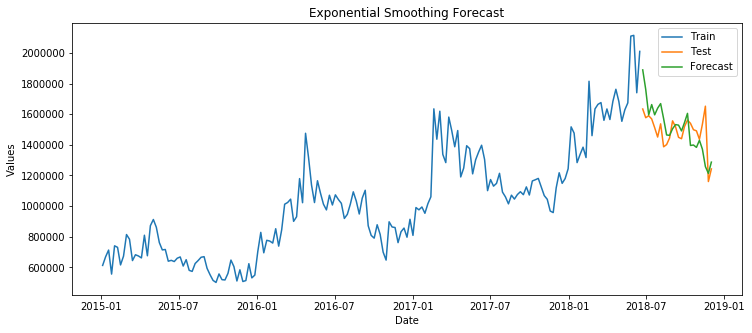

Forecasted data has been exported to forecasted_data.csv
         Date      Actual      Forecast
0  2018-06-24  1633962.12  1.889246e+06
1  2018-07-01  1577022.49  1.762115e+06
2  2018-07-08  1589877.42  1.595302e+06
3  2018-07-15  1568944.98  1.662717e+06
4  2018-07-22  1512027.80  1.595794e+06
5  2018-07-29  1450807.92  1.639309e+06
6  2018-08-05  1537041.22  1.669108e+06
7  2018-08-12  1387186.89  1.570634e+06
8  2018-08-19  1401564.09  1.464540e+06
9  2018-08-26  1444798.30  1.461792e+06
10 2018-09-02  1556510.73  1.504955e+06
11 2018-09-09  1517213.66  1.532100e+06
12 2018-09-16  1449050.99  1.528553e+06
13 2018-09-23  1439915.54  1.490955e+06
14 2018-09-30  1519326.55  1.545309e+06
15 2018-10-07  1561631.06  1.605330e+06
16 2018-10-14  1540282.85  1.395746e+06
17 2018-10-21  1498750.04  1.398884e+06
18 2018-10-28  1491232.38  1.383462e+06
19 2018-11-04  1436243.31  1.429663e+06
20 2018-11-11  1534804.73  1.371238e+06
21 2018-11-18  1652276.32  1.257883e+06
22 2018-11-25  1160387.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def exp_smoothing(train, test, trend='add', seasonal='add', period=1, freq='D', plot=False, figsize=(12, 5), export_file=None):
    # Your existing code for exponential smoothing
    model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=period, freq=freq)
    fit = model.fit()
    forecast = fit.forecast(len(test))

    if plot:
        plt.figure(figsize=figsize)
        plt.plot(train.index, train, label='Train')
        plt.plot(test.index, test, label='Test')
        plt.plot(test.index, forecast, label='Forecast')
        plt.title('Exponential Smoothing Forecast')
        plt.xlabel('Date')
        plt.ylabel('Values')
        plt.legend()
        plt.show()

    # Convert test to a 1-dimensional array
    test_values = test.values.flatten()

    # Create a DataFrame with results
    result_df = pd.DataFrame({
        'Date': test.index,
        'Actual': test_values,
        'Forecast': forecast.values
    })

    # Export the forecasted data to a CSV file if export_file is provided
    if export_file:
        result_df.to_csv(export_file, index=False)
        print(f'Forecasted data has been exported to {export_file}')

    return result_df, forecast

# Example usage with exporting to a CSV file
# Specify the export file path
export_file_path = 'forecasted_data.csv'

# Perform exponential smoothing and export the results to a CSV file
result_df, forecast = exp_smoothing(train, test, trend='additive', seasonal='multiplicative', period=54, freq='W', plot=True, figsize=(12, 5), export_file=export_file_path)

# Display the result DataFrame
print(result_df)
